# Gaussian Processes vs Kernel Ridge Regression

Analysis code for the portfolio performance dataset.

We use:
- **Inputs**: weights of the stock-picking concepts (6 features).
- **Target**: normalized annual return ("all period" sheet).

## Imports

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from scipy.linalg import cholesky, solve_triangular
from scipy.optimize import minimize

## RBF kernel

In [6]:
def rbf_kernel(X1, X2, lengthscale, variance):
    """
    Squared exponential / RBF kernel.

    k(x, x') = variance * exp( - 0.5 * ||x - x'||^2 / lengthscale^2 )

    Parameters
    ----------
    X1 : array, shape (n1, D)
    X2 : array, shape (n2, D)
    lengthscale : float > 0
    variance : float > 0   (this is sigma_f^2 in R&W)

    Returns
    -------
    K : array, shape (n1, n2)
        Kernel matrix.
    """
    X1 = np.atleast_2d(X1)
    X2 = np.atleast_2d(X2)
    # Squared Euclidean distance matrix
    sqdist = (
        np.sum(X1**2, axis=1)[:, None]
        + np.sum(X2**2, axis=1)[None, :]
        - 2.0 * X1.dot(X2.T)
    )
    return variance * np.exp(-0.5 * sqdist / (lengthscale ** 2))

## Gaussian Process regression (zero mean, RBF kernel, Gaussian noise)

In [7]:
def gp_neg_log_marginal_likelihood(theta_log, X, y):
    """
    Negative log marginal likelihood for GP regression with RBF kernel.

    theta_log = [log(ell), log(sigma_f), log(sigma_n)]
    """
    ell, sigma_f, sigma_n = np.exp(theta_log)

    K = rbf_kernel(X, X, ell, sigma_f ** 2)
    Ky = K + sigma_n ** 2 * np.eye(X.shape[0])

    try:
        L = cholesky(Ky, lower=True, check_finite=False)
    except np.linalg.LinAlgError:
        # Numerical issue -> huge penalty
        return 1e10

    alpha = solve_triangular(
        L.T,
        solve_triangular(L, y, lower=True, check_finite=False),
        lower=False,
        check_finite=False,
    )

    log_det = 2.0 * np.sum(np.log(np.diag(L)))
    n = X.shape[0]
    nll = 0.5 * y.dot(alpha) + 0.5 * log_det + 0.5 * n * np.log(2.0 * np.pi)
    return nll


def gp_fit_marginal_likelihood(X, y, initial_log_theta=None, bounds=None):
    """
    Fit GP hyperparameters by minimizing the negative log marginal likelihood.

    Returns a dict with ell, sigma_f, sigma_n and the full optimizer result.
    """
    if initial_log_theta is None:
        y_std = np.std(y)
        if y_std == 0:
            y_std = 1.0
        initial = np.log([1.0, y_std, 0.1 * y_std])  # heuristic
    else:
        initial = np.asarray(initial_log_theta)

    if bounds is None:
        # log-params in [log(1e-3), log(1e3)]
        bounds = [(-7, 7), (-7, 7), (-7, 7)]

    res = minimize(
        gp_neg_log_marginal_likelihood,
        initial,
        args=(X, y),
        method="L-BFGS-B",
        bounds=bounds,
    )

    ell, sigma_f, sigma_n = np.exp(res.x)
    return {"ell": ell, "sigma_f": sigma_f, "sigma_n": sigma_n, "opt_result": res}


def gp_predict(X_train, y_train, X_test, ell, sigma_f, sigma_n, return_var=True):
    """
    GP posterior predictive at X_test.

    Returns
    -------
    mean : (n_test,)
    var  : (n_test,)  (if return_var=True)
    """
    K = rbf_kernel(X_train, X_train, ell, sigma_f ** 2)
    Ky = K + sigma_n ** 2 * np.eye(X_train.shape[0])

    L = cholesky(Ky, lower=True, check_finite=False)
    alpha = solve_triangular(
        L.T,
        solve_triangular(L, y_train, lower=True, check_finite=False),
        lower=False,
        check_finite=False,
    )

    K_star = rbf_kernel(X_train, X_test, ell, sigma_f ** 2)
    mean = K_star.T.dot(alpha)

    if not return_var:
        return mean

    v = solve_triangular(L, K_star, lower=True, check_finite=False)
    K_starstar = rbf_kernel(X_test, X_test, ell, sigma_f ** 2)
    cov = K_starstar - v.T.dot(v)
    var = np.clip(np.diag(cov), 0.0, np.inf)  # numeric safety

    return mean, var


def gp_cross_validation(X, y, ell_grid, sigma_f_grid, sigma_n_grid,
                        n_splits=5, random_state=0, verbose=False):
    """
    Grid-search K-fold cross-validation for GP hyperparameters.

    For each (ell, sigma_f, sigma_n), we treat them as fixed and
    evaluate CV MSE using the GP predictive mean.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    best_params = None
    best_mse = np.inf

    for ell in ell_grid:
        for sigma_f in sigma_f_grid:
            for sigma_n in sigma_n_grid:
                mse_folds = []
                for train_idx, val_idx in kf.split(X):
                    X_tr, X_val = X[train_idx], X[val_idx]
                    y_tr, y_val = y[train_idx], y[val_idx]
                    y_pred_val = gp_predict(
                        X_tr, y_tr, X_val,
                        ell, sigma_f, sigma_n,
                        return_var=False
                    )
                    mse_folds.append(mean_squared_error(y_val, y_pred_val))

                mse_cv = float(np.mean(mse_folds))
                if verbose:
                    print(f"GP-CV ell={ell:.3g}, sigma_f={sigma_f:.3g}, "
                          f"sigma_n={sigma_n:.3g}, CV MSE={mse_cv:.4g}")

                if mse_cv < best_mse:
                    best_mse = mse_cv
                    best_params = {"ell": ell, "sigma_f": sigma_f, "sigma_n": sigma_n}

    return best_params, best_mse

## Kernel Ridge Regression

In [8]:
def krr_fit(X, y, lambd, ell, sigma_f):
    """
    Kernel ridge regression with RBF kernel.

    Objective:
        (1/(2n)) * ||y - f||^2 + (lambda / 2) * ||f||^2_{H_k}

    Solution:
        alpha = (K + lambda * n * I)^{-1} y

    Returns a model dict.
    """
    n = X.shape[0]
    K = rbf_kernel(X, X, ell, sigma_f ** 2)
    A = K + lambd * n * np.eye(n)
    alpha = np.linalg.solve(A, y)
    return {
        "alpha": alpha,
        "X_train": X.copy(),
        "ell": ell,
        "sigma_f": sigma_f,
        "lambd": lambd,
    }


def krr_predict(model, X_test):
    """Predict with KRR model."""
    K_star = rbf_kernel(
        model["X_train"], X_test,
        model["ell"], model["sigma_f"] ** 2
    )
    y_pred = K_star.T.dot(model["alpha"])
    return y_pred


def krr_cross_validation(X, y, lambd_grid, ell_grid, sigma_f_grid,
                         n_splits=5, random_state=0, verbose=False):
    """
    Grid-search K-fold CV for KRR hyperparameters (lambda, ell, sigma_f).
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    best_params = None
    best_mse = np.inf

    for lambd in lambd_grid:
        for ell in ell_grid:
            for sigma_f in sigma_f_grid:
                mse_folds = []
                for train_idx, val_idx in kf.split(X):
                    X_tr, X_val = X[train_idx], X[val_idx]
                    y_tr, y_val = y[train_idx], y[val_idx]

                    model = krr_fit(X_tr, y_tr, lambd, ell, sigma_f)
                    y_pred = krr_predict(model, X_val)
                    mse_folds.append(mean_squared_error(y_val, y_pred))

                mse_cv = float(np.mean(mse_folds))
                if verbose:
                    print(
                        f"KRR-CV lambda={lambd:.3g}, ell={ell:.3g}, "
                        f"sigma_f={sigma_f:.3g}, CV MSE={mse_cv:.4g}"
                    )

                if mse_cv < best_mse:
                    best_mse = mse_cv
                    best_params = {"lambd": lambd, "ell": ell, "sigma_f": sigma_f}

    return best_params, best_mse

## Data loading: portfolio dataset (`all period` sheet)

In [9]:
def load_portfolio_dataset_all_period(path):
    """
    Load 'all period' sheet and build:
      X = weights of stock-picking concepts (n x 6)
      y = normalized annual return (n,)

    Columns are taken directly from the Excel multi-index header.
    """
    xls = pd.ExcelFile(path)
    df = pd.read_excel(xls, sheet_name="all period", header=[0, 1])

    # Input columns: the weight of the stock-picking concept
    weight_cols = [
        col for col in df.columns
        if col[0].startswith("the weight")
    ]

    # Target column: normalized annual return
    target_col = (
        'the normalized  investment performance indicator',
        'Annual Return',
    )

    df_sub = df[weight_cols + [target_col]].dropna()
    X = df_sub[weight_cols].to_numpy(dtype=float)
    y = df_sub[target_col].to_numpy(dtype=float)

    return X, y

## Full experiment: GP-ML, GP-CV, KRR-CV

In [10]:
def run_experiment_with_gp_and_krr(path, test_size=0.3, random_state=0):
    # ----- Load data -----
    X, y = load_portfolio_dataset_all_period(path)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Standardize X and y (common in GP practice)
    X_scaler = StandardScaler().fit(X_train)
    X_train_s = X_scaler.transform(X_train)
    X_test_s = X_scaler.transform(X_test)

    y_mean = np.mean(y_train)
    y_std = np.std(y_train)
    if y_std == 0:
        y_std = 1.0
    y_train_s = (y_train - y_mean) / y_std

    print("Training points:", X_train_s.shape[0],
          " Test points:", X_test_s.shape[0])

    # ===========================
    # 1) GP with marginal likelihood
    # ===========================
    print("\nFitting GP (RBF kernel) by marginal likelihood...")
    gp_ml_params = gp_fit_marginal_likelihood(X_train_s, y_train_s)
    print("GP-ML hyperparameters (scaled space):")
    print(gp_ml_params)

    gp_ml_mean_s, gp_ml_var_s = gp_predict(
        X_train_s, y_train_s, X_test_s,
        gp_ml_params["ell"], gp_ml_params["sigma_f"], gp_ml_params["sigma_n"],
        return_var=True,
    )
    gp_ml_mean = y_mean + y_std * gp_ml_mean_s
    gp_ml_std = np.sqrt(gp_ml_var_s) * y_std
    gp_ml_mse = mean_squared_error(y_test, gp_ml_mean)

    # Mean negative log predictive density (NLPD)
    nlpd_terms = []
    for yi, mu, sigma in zip(y_test, gp_ml_mean, gp_ml_std):
        var = max(sigma ** 2, 1e-9)
        nlpd = 0.5 * np.log(2.0 * np.pi * var) + 0.5 * (yi - mu) ** 2 / var
        nlpd_terms.append(nlpd)
    gp_ml_nlpd = float(np.mean(nlpd_terms))

    print(f"GP-ML test MSE:  {gp_ml_mse:.4f}")
    print(f"GP-ML mean NLPD: {gp_ml_nlpd:.4f}")

    # ===========================
    # 2) GP hyperparameters via cross-validation
    # ===========================
    print("\nTuning GP hyperparameters by cross-validation (grid search)...")
    ell_grid = np.linspace(2, 4, 30)
    sigma_f_grid = np.linspace(1.2, 2, 30)
    sigma_n_grid = np.logspace(-2, -1, 30)

    gp_cv_best, gp_cv_mse_cv = gp_cross_validation(
        X_train_s, y_train_s,
        ell_grid, sigma_f_grid, sigma_n_grid,
        n_splits=5, random_state=random_state, verbose=False,
    )
    print("Best GP-CV hyperparameters (scaled space):")
    print(gp_cv_best)
    print(f"Best GP-CV CV MSE (scaled y): {gp_cv_mse_cv:.4f}")

    gp_cv_mean_s, gp_cv_var_s = gp_predict(
        X_train_s, y_train_s, X_test_s,
        gp_cv_best["ell"], gp_cv_best["sigma_f"], gp_cv_best["sigma_n"],
        return_var=True,
    )
    gp_cv_mean = y_mean + y_std * gp_cv_mean_s
    gp_cv_std = np.sqrt(gp_cv_var_s) * y_std
    gp_cv_mse = mean_squared_error(y_test, gp_cv_mean)

    nlpd_terms = []
    for yi, mu, sigma in zip(y_test, gp_cv_mean, gp_cv_std):
        var = max(sigma ** 2, 1e-9)
        nlpd = 0.5 * np.log(2.0 * np.pi * var) + 0.5 * (yi - mu) ** 2 / var
        nlpd_terms.append(nlpd)
    gp_cv_nlpd = float(np.mean(nlpd_terms))

    print(f"GP-CV test MSE:  {gp_cv_mse:.4f}")
    print(f"GP-CV mean NLPD: {gp_cv_nlpd:.4f}")

    # ===========================
    # 3) Kernel ridge regression via CV
    # ===========================
    print("\nTuning Kernel Ridge Regression by cross-validation...")
    lambd_grid = np.logspace(-4.5, -3.5, 30)
    ell_grid_krr = np.linspace(2, 4, 30)
    sigma_f_grid_krr = np.linspace(1.2, 2, 30)

    krr_best, krr_best_mse_cv = krr_cross_validation(
        X_train_s, y_train_s,
        lambd_grid, ell_grid_krr, sigma_f_grid_krr,
        n_splits=5, random_state=random_state, verbose=False,
    )
    print("Best KRR hyperparameters (scaled space):")
    print(krr_best)
    print(f"Best KRR CV MSE (scaled y): {krr_best_mse_cv:.4f}")

    krr_model = krr_fit(
        X_train_s, y_train_s,
        krr_best["lambd"], krr_best["ell"], krr_best["sigma_f"],
    )
    krr_pred_s = krr_predict(krr_model, X_test_s)
    krr_pred = y_mean + y_std * krr_pred_s
    krr_mse = mean_squared_error(y_test, krr_pred)
    print(f"KRR test MSE: {krr_mse:.4f}")

    # ===========================
    # 4) Direct comparison GP mean vs KRR prediction
    # ===========================
    gp_ml_mean_s_only = gp_predict(
        X_train_s, y_train_s, X_test_s,
        gp_ml_params["ell"], gp_ml_params["sigma_f"], gp_ml_params["sigma_n"],
        return_var=False,
    )
    diff = gp_ml_mean_s_only - krr_pred_s
    print("\nDifference between GP-ML mean and KRR prediction (scaled y):")
    print(f"  Mean |diff|: {np.mean(np.abs(diff)):.4e}")
    print(f"  Max  |diff|: {np.max(np.abs(diff)):.4e}")

    # ===========================
    # 5) Summary table of results
    # ===========================
    summary = pd.DataFrame(
        {
            "Test MSE": [
                gp_ml_mse,
                gp_cv_mse,
                krr_mse,
            ],
            "Mean NLPD": [
                gp_ml_nlpd,
                gp_cv_nlpd,
                np.nan,      # not defined for KRR
            ],
            "CV MSE (scaled y)": [
                np.nan,          # GP-ML doesn't use CV
                gp_cv_mse_cv,
                krr_best_mse_cv,
            ],
            "ell": [
                gp_ml_params["ell"],
                gp_cv_best["ell"],
                krr_best["ell"],
            ],
            "sigma_f": [
                gp_ml_params["sigma_f"],
                gp_cv_best["sigma_f"],
                krr_best["sigma_f"],
            ],
            "sigma_n / lambda": [
                gp_ml_params["sigma_n"],
                gp_cv_best["sigma_n"],
                krr_best["lambd"],
            ],
        },
        index=["GP-ML", "GP-CV", "KRR-CV"],
    )

    print("\n========== Summary of results ==========")
    print(summary)
    print("========================================\n")

    # Return everything for further analysis / plotting
    results = {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
        "X_train_s": X_train_s,
        "X_test_s": X_test_s,
        "y_train_s": y_train_s,
        "gp_ml_params": gp_ml_params,
        "gp_ml_test_mse": gp_ml_mse,
        "gp_ml_test_nlpd": gp_ml_nlpd,
        "gp_cv_best": gp_cv_best,
        "gp_cv_test_mse": gp_cv_mse,
        "gp_cv_test_nlpd": gp_cv_nlpd,
        "krr_best": krr_best,
        "krr_test_mse": krr_mse,
    }
    return results

## Plots

In [23]:
from sklearn.preprocessing import StandardScaler

def _recompute_scalers(results):
    """
    Rebuild the scalers used in run_experiment_with_gp_and_krr,
    based on X_train and y_train stored in `results`.
    """
    X_train = results["X_train"]
    y_train = results["y_train"]

    X_scaler = StandardScaler().fit(X_train)
    y_mean = np.mean(y_train)
    y_std = np.std(y_train)
    if y_std == 0:
        y_std = 1.0

    return X_scaler, y_mean, y_std



def plot_parity(results, save_path=None):
    """
    Parity plot: y_true vs y_pred for GP-ML, GP-CV, and KRR-CV (test set).
    Uses common x/y limits across all panels.
    If save_path is not None, saves the figure there.
    """
    X_train_s = results["X_train_s"]
    X_test_s = results["X_test_s"]
    y_train_s = results["y_train_s"]
    y_test = results["y_test"]

    # scalers to go back to original y scale
    X_scaler, y_mean, y_std = _recompute_scalers(results)

    # GP-ML predictions
    gp_ml_params = results["gp_ml_params"]
    gp_ml_mean_s, _ = gp_predict(
        X_train_s, y_train_s, X_test_s,
        gp_ml_params["ell"], gp_ml_params["sigma_f"], gp_ml_params["sigma_n"],
        return_var=True,
    )
    gp_ml_mean = y_mean + y_std * gp_ml_mean_s

    # GP-CV predictions
    gp_cv_best = results["gp_cv_best"]
    gp_cv_mean_s, _ = gp_predict(
        X_train_s, y_train_s, X_test_s,
        gp_cv_best["ell"], gp_cv_best["sigma_f"], gp_cv_best["sigma_n"],
        return_var=True,
    )
    gp_cv_mean = y_mean + y_std * gp_cv_mean_s

    # KRR-CV predictions
    krr_best = results["krr_best"]
    krr_model = krr_fit(
        X_train_s, y_train_s,
        krr_best["lambd"], krr_best["ell"], krr_best["sigma_f"],
    )
    krr_pred_s = krr_predict(krr_model, X_test_s)
    krr_pred = y_mean + y_std * krr_pred_s

    # Common axis limits
    global_min = min(y_test.min(), gp_ml_mean.min(), gp_cv_mean.min(), krr_pred.min())
    global_max = max(y_test.max(), gp_ml_mean.max(), gp_cv_mean.max(), krr_pred.max())
    margin = 0.02 * (global_max - global_min)
    global_min -= margin
    global_max += margin

    # Plot
    fig = plt.figure(figsize=(12, 4))
    models = [
        ("GP-ML", gp_ml_mean),
        ("GP-CV", gp_cv_mean),
        ("KRR-CV", krr_pred),
    ]

    for i, (name, y_pred) in enumerate(models, 1):
        ax = fig.add_subplot(1, 3, i)
        ax.scatter(y_test, y_pred, alpha=0.7)
        ax.plot(
            [global_min, global_max],
            [global_min, global_max],
            linestyle="--"
        )
        ax.set_xlim(global_min, global_max)
        ax.set_ylim(global_min, global_max)
        ax.set_xlabel("True normalized annual return")
        ax.set_ylabel("Predicted normalized annual return")
        ax.set_title(name)

    fig.suptitle("Parity plot: true vs predicted on test set", y=1.02)
    fig.tight_layout()

    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()



def plot_1d_slice(results, feature_index=0, feature_names=None,
                  n_points=200, save_path=None):
    """
    Plot a 1D slice along one input dimension:

    - Fix all but one feature at the mean (in standardized space).
    - Vary the chosen feature.
    - Show GP-ML mean ± 2 std and KRR-CV curve, plus training points.

    Parameters
    ----------
    feature_index : int
        Index of the feature (0-based).
    feature_names : list of str or None
        Optional list of feature names to use for x-axis labels.
    """
    X_train = results["X_train"]
    y_train = results["y_train"]
    X_train_s = results["X_train_s"]
    y_train_s = results["y_train_s"]

    X_scaler, y_mean, y_std = _recompute_scalers(results)

    # Base point: mean of standardized X
    x0_s = X_train_s.mean(axis=0)
    f = feature_index

    # Range along this feature (in standardized space)
    f_min = X_train_s[:, f].min()
    f_max = X_train_s[:, f].max()
    grid_f = np.linspace(f_min, f_max, n_points)

    X_grid_s = np.tile(x0_s, (n_points, 1))
    X_grid_s[:, f] = grid_f

    # Back to original scale for x-axis
    X_grid = X_scaler.inverse_transform(X_grid_s)
    x_axis = X_grid[:, f]

    # GP-ML on grid
    gp_ml_params = results["gp_ml_params"]
    gp_ml_mean_s_grid, gp_ml_var_s_grid = gp_predict(
        X_train_s, y_train_s, X_grid_s,
        gp_ml_params["ell"], gp_ml_params["sigma_f"], gp_ml_params["sigma_n"],
        return_var=True,
    )
    gp_ml_mean_grid = y_mean + y_std * gp_ml_mean_s_grid
    gp_ml_std_grid = np.sqrt(gp_ml_var_s_grid) * y_std

    # KRR-CV on grid
    krr_best = results["krr_best"]
    krr_model = krr_fit(
        X_train_s, y_train_s,
        krr_best["lambd"], krr_best["ell"], krr_best["sigma_f"],
    )
    krr_pred_s_grid = krr_predict(krr_model, X_grid_s)
    krr_pred_grid = y_mean + y_std * krr_pred_s_grid

    # Training data projected on this feature (original scale)
    X_train_orig = X_train  # already original scale
    x_train_axis = X_train_orig[:, f]
    y_train_axis = y_train

    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(1, 1, 1)

    ax.plot(x_axis, gp_ml_mean_grid, label="GP-ML mean")
    ax.fill_between(
        x_axis,
        gp_ml_mean_grid - 2 * gp_ml_std_grid,
        gp_ml_mean_grid + 2 * gp_ml_std_grid,
        alpha=0.3,
        label="GP-ML ± 2 std",
    )
    ax.plot(x_axis, krr_pred_grid, linestyle="--", label="KRR-CV")

    # Training data (no jitter)
    ax.scatter(x_train_axis, y_train_axis, alpha=0.7, label="Train data")

    # Nice x-axis label
    if feature_names is not None and feature_index < len(feature_names):
        xlabel = feature_names[feature_index]
    else:
        xlabel = f"Input feature {feature_index} (original scale)"

    ax.set_xlabel(xlabel)
    ax.set_ylabel("Normalized annual return")
    ax.set_title(f"1D slice along feature {feature_index}")
    ax.legend()
    fig.tight_layout()

    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()



def make_all_plots(results, feature_names=None):
    """
    Generate parity plot + 1D slice for each feature.
    """
    plot_parity(results, save_path="parity_plot.png")

    n_features = results["X_train"].shape[1]
    for f in range(n_features):
        fname = f"slice_feature{f}.png"
        plot_1d_slice(results,
                      feature_index=f,
                      feature_names=feature_names,
                      save_path=fname)    

## Run Regression

In [16]:
# Change this if the file is elsewhere
DATA_PATH = "stock portfolio performance data set.xlsx"

results = run_experiment_with_gp_and_krr(DATA_PATH)

Training points: 44  Test points: 19

Fitting GP (RBF kernel) by marginal likelihood...
GP-ML hyperparameters (scaled space):
{'ell': np.float64(2.814297759425477), 'sigma_f': np.float64(1.2635650242625227), 'sigma_n': np.float64(0.08822606992900126), 'opt_result':   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 21.554340102214695
        x: [ 1.035e+00  2.339e-01 -2.428e+00]
      nit: 13
      jac: [-1.634e-05  4.192e-05 -1.918e-05]
     nfev: 84
     njev: 21
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>}
GP-ML test MSE:  0.0018
GP-ML mean NLPD: -1.3586

Tuning GP hyperparameters by cross-validation (grid search)...
Best GP-CV hyperparameters (scaled space):
{'ell': np.float64(3.310344827586207), 'sigma_f': np.float64(1.282758620689655), 'sigma_n': np.float64(0.03856620421163472)}
Best GP-CV CV MSE (scaled y): 0.1702
GP-CV test MSE:  0.0018
GP-CV mean NLPD: 1.5775

Tuning Kernel Ridge Regression by cross-validation...

## Run Plots

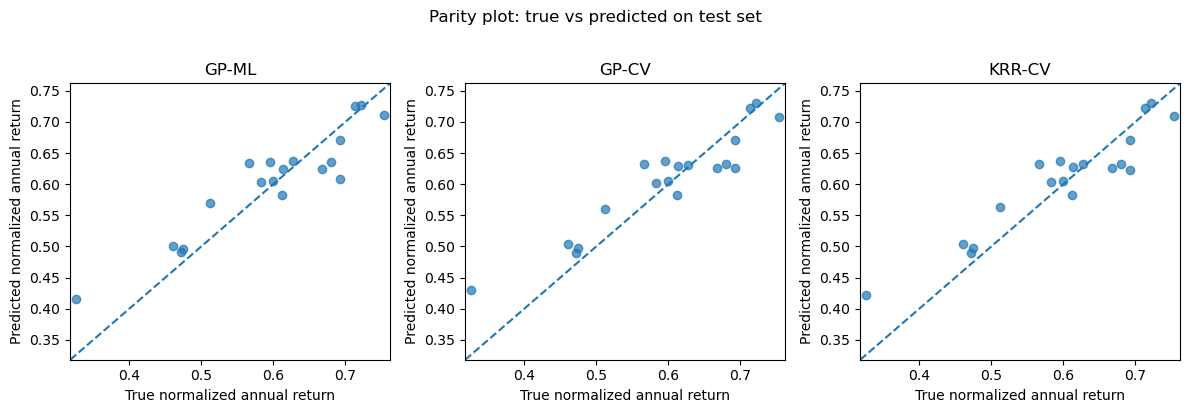

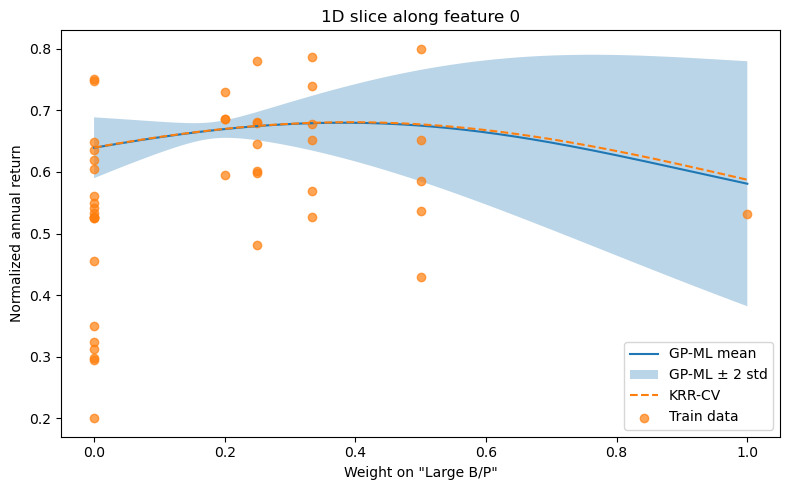

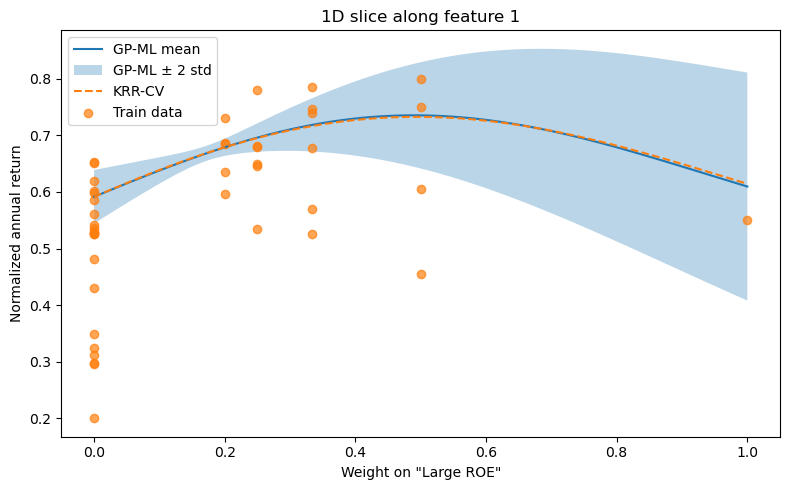

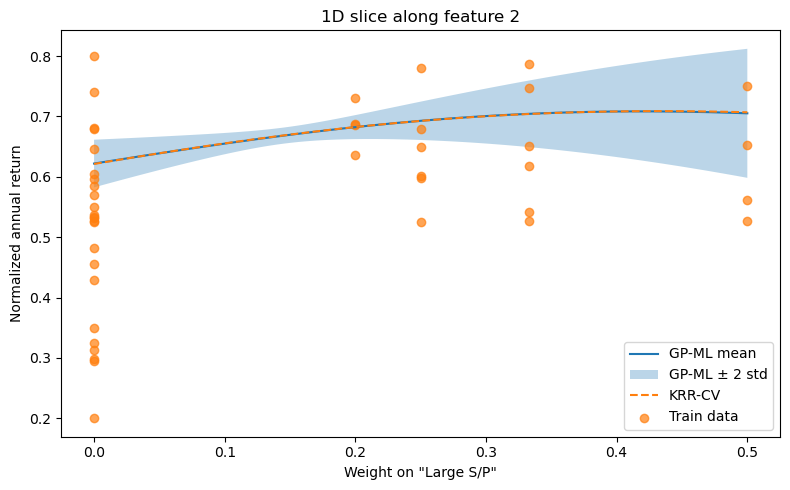

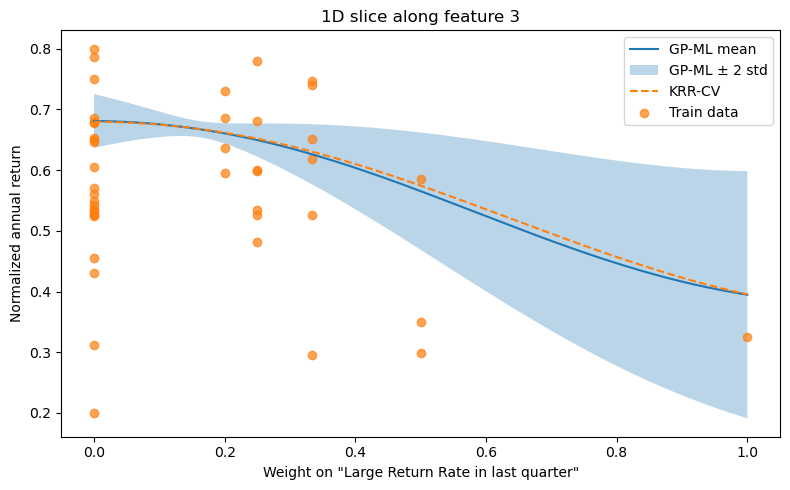

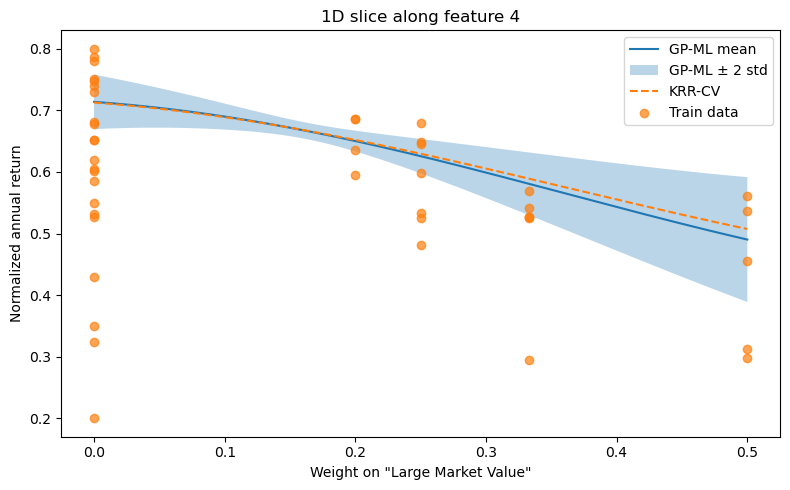

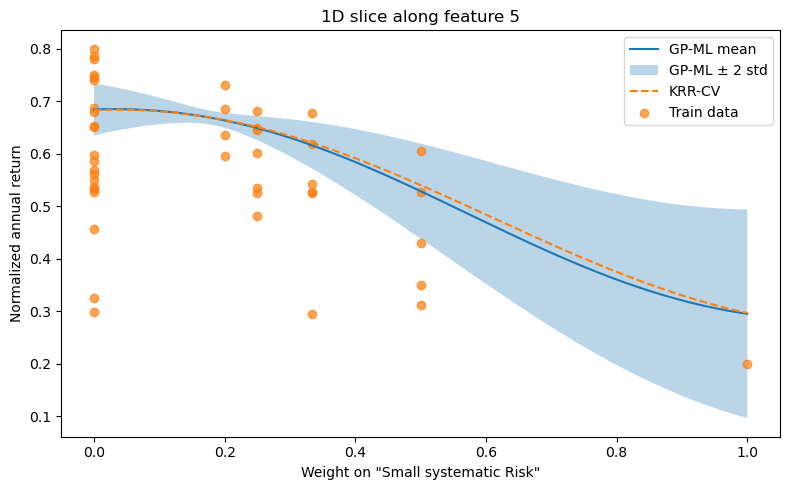

In [24]:
# Feature names in the same order as your 6 weight columns
feature_names = [
    'Weight on "Large B/P"',
    'Weight on "Large ROE"',
    'Weight on "Large S/P"',
    'Weight on "Large Return Rate in last quarter"',
    'Weight on "Large Market Value"',
    'Weight on "Small systematic Risk"',
]

make_all_plots(results, feature_names=feature_names)